# RRIoT 

#### Recurrent Reinforcement Learning for Cyber Threat Detection on IoT Devices
This code covers the implementation of the RRIoT algorithm as described in the manuscript "RRIoT: Recurrent Reinforcement Learning for Cyber Threat Detection on IoT devices." This code was adapted from another repository, https://github.com/gcamfer/Anomaly-ReactionRL and edited to reflect changes per our manuscript. For our code, we have included primarily the TON-IoT Modbus tracker dataset; the GPS and weather datasets follow a similar implementation. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, SimpleRNN, LSTM, Reshape
from keras import optimizers
from keras import backend as K

import json
import os
import sys
import time

C:\Users\crookard\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Data Preprocessing

         ts  FC1_Read_Input_Register  FC2_Read_Discrete_Value  \
0  1.354860                 0.880767                 1.059439   
1  1.354860                 0.880767                 1.059439   
2  1.354861                 0.880767                 1.059439   
3  1.354862                 0.880767                 1.059439   
4  1.354864                 0.418756                 0.629579   

   FC3_Read_Holding_Register  FC4_Read_Coil       type  
0                  -0.355937      -1.017983  injection  
1                  -0.355937      -1.017983  injection  
2                  -0.355937      -1.017983  injection  
3                  -0.355937      -1.017983  injection  
4                  -0.602912       0.134802  injection  


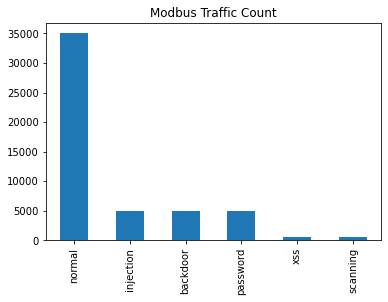

In [2]:
data = pd.read_csv('C:\\Users\\crookard\\Desktop\\TON-IoT\\Train_Test_IoT_Modbus.csv', sep=',')

#Keep Only Best Features
data = data[['ts','FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil','type']] 

# Creating Histogram 
data['type'].value_counts().plot(kind='bar', title='Modbus Traffic Count')

# Columns to be transformed (excluding 'type')
columns_to_transform = data.columns.drop('type')

# Applying Standard Scaler to these columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_to_transform])

# Convert the scaled data back to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_transform)

# Reset index for the 'type' column to align the data
type_series = data['type'].reset_index(drop=True)

# Concatenating the scaled data with the 'type' column
final_data = pd.concat([data_scaled_df, type_series], axis=1)

print(final_data.head())

In [3]:
#Split the Data and then Write to CSV
train, test = train_test_split(final_data, test_size=0.20)

train.to_csv('RRIoT\\TON_GPS_train.txt',sep=',',index=False)
test.to_csv('RRIoT\\TON_GPS_test.txt',sep=',',index=False)

train.to_csv('RRIoT\\TON_GPS_train.csv',sep=',',index=False)
test.to_csv('RRIoT\\TON_GPS_test.csv',sep=',',index=False)

In [4]:
train_path = 'C:\\Users\\crookard\\Desktop\\Anomaly-RL_Full\\Notebooks\\RRIoT\\TON_GPS_train.txt'
test_path = 'C:\\Users\\crookard\\Desktop\\Anomaly-RL_Full\\Notebooks\\RRIoT\\TON_GPS_test.txt'

In [5]:
class data_cls:
    def __init__(self,train_test,**kwargs):
        col_names = ['ts', 'FC1_Read_Input_Register','FC2_Read_Discrete_Value',
                     'FC3_Read_Holding_Register','FC4_Read_Coil','type']
        
        # Data formated path and test path. 
        self.train_test = train_test
     
        self.index = 0
        if(train_test=="train"):
          self.train_path = train_path
        else:
          self.train_path = test_path
        
        self.df = pd.read_csv(self.train_path,sep=',')    
        
        #self.attack_types = ['normal','attack']
        #self.attack_names = ['normal','attack']
        #self.attack_map = {'normal':'normal', 'attack':'attack'}
               
        self.attack_types = ['normal', 'backdoor', 'injection', 'password', 'xss', 'scanning']
        self.attack_names = ['normal', 'backdoor', 'injection', 'password', 'xss', 'scanning']
        self.attack_map = {'normal':'normal', 
                           'backdoor':'backdoor', 
                           'injection':'injection', 
                           'password':'password', 
                           'xss':'xss', 
                           'scanning':'scanning'}

        self.all_attack_names = list(self.attack_map.keys())
        
        self.df = pd.concat([self.df.drop('type', axis=1), pd.get_dummies(self.df['type'])], axis=1)
        
    def get_shape(self):
              
        self.data_shape = self.df.shape
        # stata + labels
        return self.data_shape
    
    ''' Get n-rows from loaded data 
        The dataset must be loaded in RAM
    '''
    def get_batch(self,batch_size=100):
                
        # Read the df rows
        indexes = list(range(self.index,self.index+batch_size))    
        if max(indexes)>self.data_shape[0]-1:
            dif = max(indexes)-self.data_shape[0]
            indexes[len(indexes)-dif-1:len(indexes)] = list(range(dif+1))
            self.index=batch_size-dif
            batch = self.df.iloc[indexes]
        else: 
            batch = self.df.iloc[indexes]
            self.index += batch_size    
            
        labels = batch[self.attack_names]    
        batch = batch.drop(self.all_attack_names,axis=1)
            
        return batch,labels
    
    def get_full(self):
        labels = self.df[self.attack_names]
        batch = self.df.drop(self.all_attack_names,axis=1)
        
        return batch,labels
 

In [6]:
# Huber loss function        
def huber_loss(y_true, y_pred, clip_value=1):
    '''
    Huber loss, see https://en.wikipedia.org/wiki/Huber_loss and
    https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
    for more details about the Huber loss function.
    '''
    assert clip_value > 0.

    x = y_true - y_pred
    if np.isinf(clip_value):
        # Spacial case for infinity since Tensorflow does have problems
        # if we compare `K.abs(x) < np.inf`.
        return .5 * K.square(x)

    condition = K.abs(x) < clip_value
    squared_loss = .5 * K.square(x)
    linear_loss = clip_value * (K.abs(x) - .5 * clip_value)
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        if hasattr(tf, 'select'):
            return tf.select(condition, squared_loss, linear_loss)  # condition, true, false
        else:
            return tf.where(condition, squared_loss, linear_loss)  # condition, true, false
    elif K.backend() == 'theano':
        from theano import tensor as T
        return T.switch(condition, squared_loss, linear_loss)
    else:
        raise RuntimeError('Unknown backend "{}".'.format(K.backend()))

# Needed for keras huber_loss locate
import keras.losses
keras.losses.huber_loss = huber_loss


In [7]:
class QNetwork():
    """
    Q-Network Estimator
    Represents the global model for the table
    """

    def __init__(self,obs_size,num_actions,hidden_size = 100,
                 hidden_layers = 1,learning_rate=.2):
        """
        Initialize the network with the provided shape
        """
        self.obs_size = obs_size
        self.num_actions = num_actions
        
        # Network arquitecture
        self.model = Sequential()
        
        # Add input layer
        self.model.add(Dense(hidden_size, input_shape=(obs_size,),
                             activation='relu'))
        
        
        # Add hidden layers -> Edited to Reflect Architecture Changes
        for layers in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
                
        # Recurrent layer
            self.model.add(Reshape(input_shape=(hidden_size,), target_shape=(hidden_size, 1)))
            self.model.add(LSTM(hidden_size, activation='tanh'))      
            
        # Add output layer    
        self.model.add(Dense(num_actions))
        
        #optimizer = optimizers.SGD(learning_rate)
        #optimizer = optimizers.Adam(alpha=learning_rate)
        optimizer = tf.keras.optimizers.Adam(0.00025)
        #optimizer = optimizers.RMSpropGraves(learning_rate, 0.95, self.momentum, 1e-2)
        
        # Compilation of the model with optimizer and loss
        self.model.compile(loss=huber_loss,optimizer=optimizer) 
        
        # Model Summary
        self.model.summary()

    def predict(self,state,batch_size=1):
        """
        Predicts action values.
        """
        return self.model.predict(state,batch_size=batch_size)

    def update(self, states, q):
        """
        Updates the estimator with the targets.

        Args:
          states: Target states
          q: Estimated values

        Returns:
          The calculated loss on the batch.
        """
        loss = self.model.train_on_batch(states, q)
        return loss
    
    def copy_model(model):
        """Returns a copy of a keras model."""
        model.save('tmp_model')
        return keras.models.load_model('tmp_model')


In [8]:
class QNetwork_DDPG():
    """
    Q-Network Estimator
    Represents the global model for the table
    """

    def __init__(self, obs_size, num_actions, 
                 actor_hidden_size=100, critic_hidden_size=100,
                 actor_hidden_layers=1, critic_hidden_layers=1, 
                 actor_learning_rate=.0001, critic_learning_rate=.001):
        """
        Initialize the network with the provided shape
        """
        self.obs_size = obs_size
        self.num_actions = num_actions

        # Actor Network arquitecture
        self.actor_model = Sequential()

        # Add input layer
        self.actor_model.add(Dense(actor_hidden_size, input_shape=(obs_size,), activation='relu'))

        # Add hidden layers -> Edited to Reflect Architecture Changes
        for _ in range(1):
            self.actor_model.add(Dense(actor_hidden_size, activation='relu'))

            # Recurrent layer
            self.actor_model.add(Reshape(input_shape=(actor_hidden_size,), target_shape=(actor_hidden_size, 1)))
            self.actor_model.add(SimpleRNN(actor_hidden_size, activation='tanh'))
            #self.actor_model.add(LSTM(critic_hidden_size,))
            
        # Add output layer
        self.actor_model.add(Dense(num_actions, activation='tanh'))

        # Critic Network arquitecture
        self.critic_model = Sequential()

        # Add input layer
        self.critic_model.add(Dense(critic_hidden_size, input_shape=(obs_size,), activation='relu'))

        # Add hidden layers -> Edited to Reflect Architecture Changes
        for _ in range(1):
            self.critic_model.add(Dense(critic_hidden_size, activation='relu'))
            
            # Recurrent Layer 
            self.critic_model.add(Reshape(input_shape=(critic_hidden_size,), target_shape=(critic_hidden_size, 1)))
            self.critic_model.add(SimpleRNN(critic_hidden_size,))
            #self.critic_model.add(LSTM(critic_hidden_size,))            
            
        # Add output layer
        self.critic_model.add(Dense(1))

        # Define the optimizer for both actor and critic networks
        actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
        critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)

        # Compilation of the models with optimizer and loss
        self.actor_model.compile(loss='huber_loss', optimizer=actor_optimizer)
        self.critic_model.compile(loss='huber_loss', optimizer=critic_optimizer)

        # Model Summary
        self.actor_model.summary()
        self.critic_model.summary()

    def predict(self, state, batch_size=1):
        """
        Predicts action values using the actor network.
        """
        return self.actor_model.predict(state, batch_size=batch_size)

    def update(self, states, actions, q_targets):
        """
        Updates the actor and critic networks.

        Args:
          states: Target states
          actions: Estimated actions
          q_targets: Estimated values

        Returns:
          The calculated loss on the batch.
        """
        # Update critic network
        critic_loss = self.critic_model.train_on_batch([states, actions], q_targets)

        # Update actor network
        with tf.GradientTape() as tape:
            # Compute the predicted actions
            predicted_actions = self.actor_model(states)

            # Compute the critic values for the predicted actions
            critic_values = self.critic_model([states, predicted_actions])

            # Compute actor loss as negative critic value
            actor_loss = -tf.math.reduce_mean(critic_values)

        # Compute actor gradients
        actor_gradients = tape.gradient(actor_loss, self.actor_model.trainable_variables)

        # Apply actor gradients
        self.actor_model.optimizer.apply_gradients(zip(actor_gradients, self.actor_model.trainable_variables))

        return critic_loss, actor_loss

    def copy_model(model):
        """Returns a copy of a keras model."""
        model.save('tmp_model')
        return keras.models.load_model('tmp_model')

In [9]:
#Policy interface
class Policy:
    def __init__(self, num_actions, estimator):
        self.num_actions = num_actions
        self.estimator = estimator
    
class Epsilon_greedy(Policy):
    def __init__(self,estimator ,num_actions ,epsilon,min_epsilon,decay_rate, epoch_length):
        Policy.__init__(self, num_actions, estimator)
        self.name = "Epsilon Greedy"
        
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.actions = list(range(num_actions))
        self.step_counter = 0
        self.epoch_length = epoch_length
        self.decay_rate = decay_rate
        
        #if epsilon is up 0.1, it will be decayed over time
        if self.epsilon > 0.01:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False
    
    def get_actions(self,states):
        # get next action
        if np.random.rand() <= self.epsilon:
            actions = np.random.randint(0, self.num_actions,states.shape[0])
        else:
            self.Q = self.estimator.predict(states,states.shape[0])
            actions = []
            for row in range(self.Q.shape[0]):
                best_actions = np.argwhere(self.Q[row] == np.amax(self.Q[row]))
                actions.append(best_actions[np.random.choice(len(best_actions))].item())
            
        self.step_counter += 1 
        # decay epsilon after each epoch
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.decay_rate**self.step_counter)
            
        return actions

In [10]:
class ReplayMemory(object):
    """Implements basic replay memory"""

    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size,self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32)
        s_next = np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32)

        a      = self.samples['action'][sampled_indices].reshape(minibatch_size)
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

In [11]:
'''
Reinforcement learning Agent definition
'''

class Agent(object):  
        
    def __init__(self, actions,obs_size, policy="EpsilonGreedy", **kwargs):
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size
        
        self.epsilon = kwargs.get('epsilon', 1)
        self.min_epsilon = kwargs.get('min_epsilon', .1)
        self.gamma = kwargs.get('gamma', .001)
        self.minibatch_size = kwargs.get('minibatch_size', 2)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.decay_rate = kwargs.get('decay_rate',0.99)
        self.ExpRep = kwargs.get('ExpRep',True)
        if self.ExpRep:
            self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10))
        
        self.ddqn_time = 100
        self.ddqn_update = self.ddqn_time
        
        #self.model_network = QNetwork(self.obs_size, self.num_actions,
        #                              kwargs.get('hidden_size', 100),
        #                              kwargs.get('hidden_layers',1),
        #                              kwargs.get('learning_rate',.2))
        #self.target_model_network = QNetwork(self.obs_size, self.num_actions,
        #                              kwargs.get('hidden_size', 100),
        #                              kwargs.get('hidden_layers',1),
        #                              kwargs.get('learning_rate',.2))
        #self.target_model_network.model = QNetwork.copy_model(self.model_network.model)
        
        self.model_network = QNetwork_DDPG(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network = QNetwork_DDPG(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network.model = QNetwork_DDPG.copy_model(self.model_network.actor_model)
        
        if policy == "EpsilonGreedy":
            self.policy = Epsilon_greedy(self.model_network,len(actions),
                                         self.epsilon,self.min_epsilon,
                                         self.decay_rate,self.epoch_length)
        
        
    def learn(self, states, actions,next_states, rewards, done):
        if self.ExpRep:
            self.memory.observe(states, actions, rewards, done)
        else:
            self.states = states
            self.actions = actions
            self.next_states = next_states
            self.rewards = rewards
            self.done = done        
    def update_model(self):
        if self.ExpRep:
            (states, actions, rewards, next_states, done) = self.memory.sample_minibatch(self.minibatch_size)
        else:
            states = self.states
            rewards = self.rewards
            next_states = self.next_states
            actions = self.actions
            done = self.done
        
        next_actions = []
        # Compute Q targets
        
        #Q_prime = self.model_network.predict(next_states,self.minibatch_size)
        Q_prime = self.target_model_network.predict(next_states,self.minibatch_size)
        
        for row in range(Q_prime.shape[0]):
            best_next_actions = np.argwhere(Q_prime[row] == np.amax(Q_prime[row]))
            next_actions.append(best_next_actions[np.random.choice(len(best_next_actions))].item())
        sx = np.arange(len(next_actions))
        
        # Compute Q(s,a)
        Q = self.model_network.predict(states,self.minibatch_size)
        
        # Q-learning update
        targets = rewards.reshape(Q[sx,actions].shape) + \
                  self.gamma * Q[sx,next_actions] * \
                  (1-done.reshape(Q[sx,actions].shape))   
        Q[sx,actions] = targets  
        
        loss = self.model_network.actor_model.train_on_batch(states,Q)#inputs,targets    #UPDATED HERE     
        
        # Update Timer 
        self.ddqn_update -= 1
        if self.ddqn_update == 0:
            self.ddqn_update = self.ddqn_time
            #self.target_model_network.model = QNetwork.copy_model(self.model_network.model)
            self.target_model_network.actor_model.set_weights(self.model_network.actor_model.get_weights()) #UPDATED HERE
        return loss    

    def act(self, state,policy):
        raise NotImplementedError

In [12]:
class DefenderAgent(Agent):      
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)
        
    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions
    
class AttackAgent(Agent):      
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)
        
    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions

In [13]:
'''
Reinforcement learning Enviroment Definition
'''
class RLenv(data_cls):
    def __init__(self,train_test,**kwargs):
        data_cls.__init__(self,train_test,**kwargs)
        self.data_shape = data_cls.get_shape(self)
        self.batch_size = kwargs.get('batch_size',1) # experience replay -> batch = 1
        self.iterations_episode = kwargs.get('iterations_episode',10)

    '''
    _update_state: function to update the current state
    Returns:
        None
    Modifies the self parameters involved in the state:
        self.state and self.labels
    Also modifies the true labels to get learning knowledge
    '''
    def _update_state(self):        
        self.states,self.labels = data_cls.get_batch(self)
        
        # Update statistics
        self.true_labels += np.sum(self.labels).values

    '''
    Returns:
        + Observation of the enviroment
    '''
    def reset(self):
        # Statistics
        self.def_true_labels = np.zeros(len(self.attack_types),dtype=int)
        self.def_estimated_labels = np.zeros(len(self.attack_types),dtype=int)
        self.att_true_labels = np.zeros(len(self.attack_names),dtype=int)
        
        self.state_numb = 0
        
        self.states,self.labels = data_cls.get_batch(self,self.batch_size)
        
        self.total_reward = 0
        self.steps_in_episode = 0
        return self.states.values 
   
    '''
    Returns:
        State: Next state for the game
        Reward: Actual reward
        done: If the game ends (no end in this case)
    
    In the adversarial enviroment, it's only needed to return the actual reward
    '''    
    def act(self,defender_actions,attack_actions):
        # Clear previous rewards        
        self.att_reward = np.zeros(len(attack_actions))       
        self.def_reward = np.zeros(len(defender_actions))
                
        attack = [self.attack_types.index(self.attack_map[self.attack_names[att]]) for att in attack_actions]
    
        self.def_reward = (np.asarray(defender_actions)==np.asarray(attack))*1
        self.att_reward = (np.asarray(defender_actions)!=np.asarray(attack))*1

        self.def_estimated_labels += np.bincount(defender_actions,minlength=len(self.attack_types))      
        for act in attack_actions:
            self.def_true_labels[self.attack_types.index(self.attack_map[self.attack_names[act]])] += 1

        # Get new state and new true values 
        attack_actions = attacker_agent.act(self.states)
        self.states = env.get_states(attack_actions)
        
        # Done allways false in this continuous task       
        self.done = np.zeros(len(attack_actions),dtype=bool)
            
        return self.states, self.def_reward,self.att_reward, attack_actions, self.done
    
    '''
    Provide the actual states for the selected attacker actions
    Parameters:
        self:
        attacker_actions: optimum attacks selected by the attacker
            it can be one of attack_names list and select random of this
    Returns:
        State: Actual state for the selected attacks
    '''
    def get_states(self,attacker_actions):
        first = True
        for attack in attacker_actions:
            if first:
                minibatch = (self.df[self.df[self.attack_names[attack]]==1].sample(1))
                first = False
            else:
                minibatch=minibatch.append(self.df[self.df[self.attack_names[attack]]==1].sample(1))
        
        self.labels = minibatch[self.attack_names]
        minibatch.drop(self.all_attack_names,axis=1,inplace=True)
        self.states = minibatch
        
        return self.states



#### Training Phase

In [14]:
if __name__ == "__main__":
  
    
    # Train batch
    batch_size = 1
    # batch of memory ExpRep
    minibatch_size = 100
    ExpRep = True
    
    iterations_episode = 200
  
    # Initialization of the enviroment
    env = RLenv('train',batch_size=batch_size,
                iterations_episode=iterations_episode)    
    # obs_size = size of the state
    obs_size = env.data_shape[1]-len(env.all_attack_names)
    print(obs_size)
    num_episodes = 100  
    
    '''
    Definition for the defensor agent.
    '''
    defender_valid_actions = list(range(len(env.attack_types))) # only detect type of attack
    defender_num_actions = len(defender_valid_actions)    
    
	
    def_epsilon = 1 # exploration
    min_epsilon = 0.01 # min value for exploration
    def_gamma = 0.001
    def_decay_rate = 0.99
    
    def_hidden_size = 200
    def_hidden_layers = 2
    
    def_learning_rate = .01
    
    defender_agent = DefenderAgent(defender_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = def_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = def_decay_rate,
                          gamma = def_gamma,
                          hidden_size=def_hidden_size,
                          hidden_layers=def_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=def_learning_rate,
                          ExpRep=ExpRep)
    
    #Pretrained defender
    #defender_agent.model_network.model.load_weights("models/RRIoT_model.h5")    
    
    '''
    Definition for the attacker agent.
    In this case the exploration is better to be greater
    The correlation sould be greater too so gamma bigger
    '''
    attack_valid_actions = list(range(len(env.attack_names)))
    attack_num_actions = len(attack_valid_actions)
	
    att_epsilon = 1
    min_epsilon = 0.5 # min value for exploration

    att_gamma = 0.001
    att_decay_rate = 0.99
    
    att_hidden_layers = 1
    att_hidden_size = 100
    
    att_learning_rate = 0.2
    
    attacker_agent = AttackAgent(attack_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = att_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = att_decay_rate,
                          gamma = att_gamma,
                          hidden_size=att_hidden_size,
                          hidden_layers=att_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=att_learning_rate,
                          ExpRep=ExpRep)
    
        
    
    # Statistics
    att_reward_chain = []
    def_reward_chain = []
    att_loss_chain = []
    def_loss_chain = []
    def_total_reward_chain = []
    att_total_reward_chain = []
    
	# Print parameters
    print("-------------------------------------------------------------------------------")
    print("Total epoch: {} | Iterations in epoch: {}"
          "| Minibatch from mem size: {} | Total Samples: {}|".format(num_episodes,
                         iterations_episode,minibatch_size,
                         num_episodes*iterations_episode))
    print("-------------------------------------------------------------------------------")
    print("Dataset shape: {}".format(env.data_shape))
    print("-------------------------------------------------------------------------------")
    print("Attacker parameters: Num_actions={} | gamma={} |" 
          " epsilon={} | ANN hidden size={} | "
          "ANN hidden layers={}|".format(attack_num_actions,
                             att_gamma,att_epsilon, att_hidden_size,
                             att_hidden_layers))
    print("-------------------------------------------------------------------------------")
    print("Defense parameters: Num_actions={} | gamma={} | "
          "epsilon={} | ANN hidden size={} |"
          " ANN hidden layers={}|".format(defender_num_actions,
                              def_gamma,def_epsilon,def_hidden_size,
                              def_hidden_layers))
    print("-------------------------------------------------------------------------------")

    # Main loop
    training_start_time = time.time()
    attacks_by_epoch = []
    attack_labels_list = []
    for epoch in range(num_episodes):
        start_time = time.time()
        att_loss = 0.
        def_loss = 0.
        def_total_reward_by_episode = 0
        att_total_reward_by_episode = 0
        # Reset enviromet, actualize the data batch with random state/attacks
        states = env.reset()
        
        # Get actions for actual states following the policy
        attack_actions = attacker_agent.act(states)
        states = env.get_states(attack_actions)    
        
        done = False
       
        attacks_list = []
        # Iteration in one episode
        for i_iteration in range(iterations_episode):
            
            attacks_list.append(attack_actions[0])
            # Apply actions, get rewards and new state
            act_time = time.time()  
            defender_actions = defender_agent.act(states)
            # Environment actuation for this actions
            next_states,def_reward, att_reward,next_attack_actions, done = env.act(defender_actions,attack_actions)
            # If the epoch*batch_size*iterations_episode is largest than the df

            
            attacker_agent.learn(states,attack_actions,next_states,att_reward,done)
            defender_agent.learn(states,defender_actions,next_states,def_reward,done)
            
            act_end_time = time.time()
            
            # Train network, update loss after at least minibatch_learns
            if ExpRep and epoch*iterations_episode + i_iteration >= minibatch_size:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()
            elif not ExpRep:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()
                

            update_end_time = time.time()

            # Update the state
            states = next_states
            attack_actions = next_attack_actions
            
            
            # Update statistics
            def_total_reward_by_episode += np.sum(def_reward,dtype=np.int32)
            att_total_reward_by_episode += np.sum(att_reward,dtype=np.int32)
        
        attacks_by_epoch.append(attacks_list)
        # Update user view
        def_reward_chain.append(def_total_reward_by_episode) 
        att_reward_chain.append(att_total_reward_by_episode) 
        def_loss_chain.append(def_loss)
        att_loss_chain.append(att_loss) 

        
        end_time = time.time()
        print("\r\n|Epoch {:03d}/{:03d}| time: {:2.2f}|\r\n"
                "|Def Loss {:4.4f} | Def Reward in ep {:03d}|\r\n"
                "|Att Loss {:4.4f} | Att Reward in ep {:03d}|"
                .format(epoch, num_episodes,(end_time-start_time), 
                def_loss, def_total_reward_by_episode,
                att_loss, att_total_reward_by_episode))
        
        
        print("|Def Estimated: {}| Att Labels: {}".format(env.def_estimated_labels,
              env.def_true_labels))
        attack_labels_list.append(env.def_true_labels)
        
    # Training Time
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time

    hours, rem = divmod(total_training_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("\r|Total Training Time: {:0>2}:{:0>2}:{:05.2f}|".format(int(hours),int(minutes),seconds))

5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1200      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 reshape (Reshape)           (None, 200, 1)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 200)               40400     
                                                                 
 dense_2 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 83,006
Trainable params: 83,006
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

 simple_rnn_7 (SimpleRNN)    (None, 1)                 3         
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: tmp_model\assets
-------------------------------------------------------------------------------
Total epoch: 100 | Iterations in epoch: 200| Minibatch from mem size: 100 | Total Samples: 20000|
-------------------------------------------------------------------------------
Dataset shape: (40884, 11)
-------------------------------------------------------------------------------
Attacker parameters: Num_actions=6 | gamma=0.001 | epsilon=1 | ANN hidden size=100 | ANN hidden layers=1|
-------------------------------------------------------------------------------
Defen

1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 48ms/step

|Epoch 000/100| time: 85.31|
|Def Loss 0.6536 | Def Reward in ep 034|
|Att Loss 1.6796 | Att Reward in ep 166|
|Def Estimated: [34 36 29 38 35 28]| Att Labels: [34 31 37 29 29 40]
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 001/100| time: 200.26|
|Def Loss 1.2463 | Def Reward in ep 075|
|Att Loss 2.4330 | Att Reward in ep 125|
|Def Estimated: [39 37 36 25 27 36]| Att Labels: [31 20 30 71 18 30]
1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 002/100| time: 209.06|
|Def Loss 1.4782 | Def Reward in ep 069|
|Att Loss 2.3468 | Att Reward in ep 131|
|Def Estimated: [35 33 30 54 25 23]| Att Labels: [25 17 14 56 24 64]
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 003/100| time: 212.17|
|Def Loss 1.4548 | Def Reward in ep 064|
|Att Loss 2.1714 | Att Reward in ep 136|
|Def Estimated: [22 42 34 57 11 34]| Att Labels: [17 13 15 52 31 72]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 004/100| time: 202.55|
|Def Loss 1.5304 | Def Reward in ep 067|
|Att Loss 1.9361 | Att Reward in ep 133|
|Def Estimated: [28 53 24 59  8 28]| Att Labels: [21 25 22 45 25 62]
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 005/100| time: 210.84|
|Def Loss 1.5616 | Def Reward in ep 070|
|Att Loss 1.8823 | Att Reward in ep 130|
|Def Estimated: [18 35 18 67 11 51]| Att Labels: [14 18 24 45 25 74]
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 006/100| time: 216.82|
|Def Loss 1.6296 | Def Reward in ep 076|
|Att Loss 1.5738 | Att Reward in ep 124|
|Def Estimated: [25 45 12 66  5 47]| Att Labels: [20 19 32 45 34 50]
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 007/100| time: 216.26|
|Def Loss 1.5346 | Def Reward in ep 062|
|Att Loss 1.4213 | Att Reward in ep 138|
|Def Estimated: [20 50 15 72  3 40]| Att Labels: [15 17 49 29 60 30]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 008/100| time: 240.31|
|Def Loss 1.5997 | Def Reward in ep 073|
|Att Loss 1.4706 | Att Reward in ep 127|
|Def Estimated: [15 52 19 54 16 44]| Att Labels: [13 21 52 29 57 28]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 009/100| time: 230.65|
|Def Loss 1.6186 | Def Reward in ep 068|
|Att Loss 1.5520 | Att Reward in ep 132|
|Def Estimated: [15 50 36 42 22 35]| Att Labels: [17 13 47 33 76 14]
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 010/100| time: 218.83|
|Def Loss 1.6098 | Def Reward in ep 080|
|Att Loss 1.7922 | Att Reward in ep 120|
|Def Estimated: [18 35 48 22 51 26]| Att Labels: [17 17 57 33 61 15]


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 011/100| time: 215.88|
|Def Loss 1.6626 | Def Reward in ep 095|
|Att Loss 2.0955 | Att Reward in ep 105|
|Def Estimated: [19 47 43 22 61  8]| Att Labels: [18 23 28 51 66 14]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 012/100| time: 214.27|
|Def Loss 1.6921 | Def Reward in ep 096|
|Att Loss 2.1995 | Att Reward in ep 104|
|Def Estimated: [23 28 39 17 79 14]| Att Labels: [22 15 38 57 50 18]
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 34ms/step

|Epoch 013/100| time: 208.43|
|Def Loss 1.7937 | Def Reward in ep 090|
|Att Loss 2.0529 | Att Reward in ep 110|
|Def Estimated: [21 36 43 15 66 19]| Att Labels: [21 28 23 67 37 24]
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 014/100| time: 211.43|
|Def Loss 1.7930 | Def Reward in ep 075|
|Att Loss 1.9624 | Att Reward in ep 125|
|Def Estimated: [21 29 50 27 60 13]| Att Labels: [21 25 33 68 29 24]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 015/100| time: 210.46|
|Def Loss 1.8170 | Def Reward in ep 085|
|Att Loss 1.6886 | Att Reward in ep 115|
|Def Estimated: [13 35 36 28 53 35]| Att Labels: [12 16 37 75 27 33]
1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 016/100| time: 207.70|
|Def Loss 1.7274 | Def Reward in ep 102|
|Att Loss 1.6684 | Att Reward in ep 098|
|Def Estimated: [20 27 33 43 38 39]| Att Labels: [18 27 33 73 16 33]
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 017/100| time: 197.25|
|Def Loss 1.5906 | Def Reward in ep 096|
|Att Loss 1.9131 | Att Reward in ep 104|
|Def Estimated: [17 34 30 61 22 36]| Att Labels: [13 22 29 74 28 34]
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 45ms/step

|Epoch 018/100| time: 197.51|
|Def Loss 1.4764 | Def Reward in ep 101|
|Att Loss 1.8760 | Att Reward in ep 099|
|Def Estimated: [22 36 30 58 25 29]| Att Labels: [21 15 34 64 42 24]
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 019/100| time: 201.25|
|Def Loss 1.4357 | Def Reward in ep 097|
|Att Loss 1.9735 | Att Reward in ep 103|
|Def Estimated: [16 35 33 61 29 26]| Att Labels: [14 18 40 73 41 14]
1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 020/100| time: 192.32|
|Def Loss 1.4523 | Def Reward in ep 099|
|Att Loss 1.9931 | Att Reward in ep 101|
|Def Estimated: [15 36 39 64 26 20]| Att Labels: [15 16 51 52 51 15]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 021/100| time: 193.94|
|Def Loss 1.3122 | Def Reward in ep 112|
|Att Loss 1.9007 | Att Reward in ep 088|
|Def Estimated: [25 18 32 47 43 35]| Att Labels: [23  9 49 43 54 22]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 022/100| time: 191.31|
|Def Loss 1.4840 | Def Reward in ep 099|
|Att Loss 2.0051 | Att Reward in ep 101|
|Def Estimated: [21 22 39 38 52 28]| Att Labels: [19 18 56 37 46 24]
1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 023/100| time: 206.03|
|Def Loss 1.3380 | Def Reward in ep 110|
|Att Loss 2.1092 | Att Reward in ep 090|
|Def Estimated: [15 18 47 60 32 28]| Att Labels: [10 19 71 40 32 28]
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 48ms/step

|Epoch 024/100| time: 212.14|
|Def Loss 1.5296 | Def Reward in ep 109|
|Att Loss 2.1179 | Att Reward in ep 091|
|Def Estimated: [25 26 44 38 45 22]| Att Labels: [22 29 44 41 39 25]
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 025/100| time: 219.61|
|Def Loss 1.4647 | Def Reward in ep 117|
|Att Loss 2.0950 | Att Reward in ep 083|
|Def Estimated: [15 22 57 36 45 25]| Att Labels: [14 29 52 47 32 26]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 026/100| time: 228.24|
|Def Loss 1.4206 | Def Reward in ep 113|
|Att Loss 2.1242 | Att Reward in ep 087|
|Def Estimated: [19 25 51 27 51 27]| Att Labels: [18 21 55 49 35 22]
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step

|Epoch 027/100| time: 222.54|
|Def Loss 1.3752 | Def Reward in ep 118|
|Att Loss 2.1715 | Att Reward in ep 082|
|Def Estimated: [19 43 43 35 32 28]| Att Labels: [19 32 44 50 33 22]
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 028/100| time: 219.31|
|Def Loss 1.3264 | Def Reward in ep 111|
|Att Loss 2.1646 | Att Reward in ep 089|
|Def Estimated: [15 37 47 35 43 23]| Att Labels: [14 19 40 57 47 23]
1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 57ms/step

|Epoch 029/100| time: 217.14|
|Def Loss 1.2082 | Def Reward in ep 115|
|Att Loss 2.0562 | Att Reward in ep 085|
|Def Estimated: [20 34 41 45 36 24]| Att Labels: [20 25 46 55 39 15]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 33ms/step

|Epoch 030/100| time: 219.06|
|Def Loss 1.0274 | Def Reward in ep 120|
|Att Loss 2.0387 | Att Reward in ep 080|
|Def Estimated: [18 30 36 46 38 32]| Att Labels: [18 22 39 49 46 26]
1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 031/100| time: 217.41|
|Def Loss 1.0770 | Def Reward in ep 124|
|Att Loss 1.9000 | Att Reward in ep 076|
|Def Estimated: [22 25 29 34 49 41]| Att Labels: [20 20 48 39 44 29]
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 33ms/step

|Epoch 032/100| time: 214.85|
|Def Loss 0.9047 | Def Reward in ep 120|
|Att Loss 1.8533 | Att Reward in ep 080|
|Def Estimated: [10 32 45 39 46 28]| Att Labels: [ 8 25 45 46 50 26]
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step

|Epoch 033/100| time: 220.34|
|Def Loss 0.9837 | Def Reward in ep 123|
|Att Loss 1.8646 | Att Reward in ep 077|
|Def Estimated: [16 21 47 50 37 29]| Att Labels: [11 18 56 56 32 27]
1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 51ms/step

|Epoch 034/100| time: 220.15|
|Def Loss 0.9793 | Def Reward in ep 125|
|Att Loss 1.8495 | Att Reward in ep 075|
|Def Estimated: [24 20 50 29 50 27]| Att Labels: [21 23 51 44 34 27]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 035/100| time: 217.32|
|Def Loss 0.9288 | Def Reward in ep 130|
|Att Loss 1.7735 | Att Reward in ep 070|
|Def Estimated: [18 28 35 45 45 29]| Att Labels: [18 27 36 60 32 27]
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 45ms/step

|Epoch 036/100| time: 212.80|
|Def Loss 1.0535 | Def Reward in ep 127|
|Att Loss 1.7420 | Att Reward in ep 073|
|Def Estimated: [16 31 46 51 32 24]| Att Labels: [16 24 44 63 29 24]
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 037/100| time: 215.94|
|Def Loss 1.0156 | Def Reward in ep 119|
|Att Loss 1.7629 | Att Reward in ep 081|
|Def Estimated: [21 26 31 54 37 31]| Att Labels: [21 16 38 60 41 24]
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 58ms/step

|Epoch 038/100| time: 215.05|
|Def Loss 0.9208 | Def Reward in ep 136|
|Att Loss 1.7406 | Att Reward in ep 064|
|Def Estimated: [14 27 38 44 56 21]| Att Labels: [14 23 34 64 48 17]
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 039/100| time: 219.72|
|Def Loss 0.9195 | Def Reward in ep 119|
|Att Loss 1.7328 | Att Reward in ep 081|
|Def Estimated: [21 28 39 51 39 22]| Att Labels: [21 18 34 60 43 24]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 51ms/step

|Epoch 040/100| time: 215.56|
|Def Loss 0.8185 | Def Reward in ep 139|
|Att Loss 1.6781 | Att Reward in ep 061|
|Def Estimated: [19 28 41 49 40 23]| Att Labels: [18 20 42 57 44 19]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step

|Epoch 041/100| time: 216.79|
|Def Loss 0.8628 | Def Reward in ep 126|
|Att Loss 1.6624 | Att Reward in ep 074|
|Def Estimated: [11 21 29 65 44 30]| Att Labels: [10 21 38 63 43 25]
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 042/100| time: 215.78|
|Def Loss 0.9977 | Def Reward in ep 131|
|Att Loss 1.7071 | Att Reward in ep 069|
|Def Estimated: [18 25 27 57 41 32]| Att Labels: [18 26 34 51 40 31]
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 043/100| time: 214.37|
|Def Loss 0.9267 | Def Reward in ep 143|
|Att Loss 1.7002 | Att Reward in ep 057|
|Def Estimated: [18 28 34 53 44 23]| Att Labels: [17 21 50 46 45 21]
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 22ms/step

|Epoch 044/100| time: 216.11|
|Def Loss 0.8583 | Def Reward in ep 121|
|Att Loss 1.7111 | Att Reward in ep 079|
|Def Estimated: [23 21 33 46 51 26]| Att Labels: [21 20 46 43 49 21]
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 36ms/step

|Epoch 045/100| time: 214.76|
|Def Loss 0.9145 | Def Reward in ep 132|
|Att Loss 1.7884 | Att Reward in ep 068|
|Def Estimated: [19 21 40 48 49 23]| Att Labels: [18 18 54 43 45 22]
1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 33ms/step

|Epoch 046/100| time: 216.57|
|Def Loss 0.7919 | Def Reward in ep 140|
|Att Loss 1.7203 | Att Reward in ep 060|
|Def Estimated: [20 20 38 44 51 27]| Att Labels: [19 18 54 43 43 23]
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 48ms/step

|Epoch 047/100| time: 218.44|
|Def Loss 0.7655 | Def Reward in ep 134|
|Att Loss 1.6656 | Att Reward in ep 066|
|Def Estimated: [23 17 50 39 42 29]| Att Labels: [22 15 46 45 47 25]
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 41ms/step

|Epoch 048/100| time: 217.58|
|Def Loss 0.8128 | Def Reward in ep 146|
|Att Loss 1.6029 | Att Reward in ep 054|
|Def Estimated: [26 19 47 38 43 27]| Att Labels: [25 21 54 39 40 21]
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 52ms/step

|Epoch 049/100| time: 219.97|
|Def Loss 0.6903 | Def Reward in ep 134|
|Att Loss 1.5551 | Att Reward in ep 066|
|Def Estimated: [23 14 43 40 43 37]| Att Labels: [23 16 42 49 43 27]
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 050/100| time: 218.44|
|Def Loss 0.7386 | Def Reward in ep 144|
|Att Loss 1.5942 | Att Reward in ep 056|
|Def Estimated: [17 18 50 51 37 27]| Att Labels: [15 22 45 52 37 29]
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 41ms/step

|Epoch 051/100| time: 220.36|
|Def Loss 0.7312 | Def Reward in ep 127|
|Att Loss 1.5776 | Att Reward in ep 073|
|Def Estimated: [22 24 56 41 37 20]| Att Labels: [19 22 39 67 32 21]
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 34ms/step

|Epoch 052/100| time: 220.94|
|Def Loss 0.7343 | Def Reward in ep 148|
|Att Loss 1.6727 | Att Reward in ep 052|
|Def Estimated: [19 32 45 41 39 24]| Att Labels: [18 30 42 48 40 22]
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 053/100| time: 219.64|
|Def Loss 0.6223 | Def Reward in ep 137|
|Att Loss 1.6171 | Att Reward in ep 063|
|Def Estimated: [20 27 30 53 49 21]| Att Labels: [18 22 40 52 48 20]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 55ms/step

|Epoch 054/100| time: 222.21|
|Def Loss 0.7177 | Def Reward in ep 143|
|Att Loss 1.6534 | Att Reward in ep 057|
|Def Estimated: [12 24 32 60 50 22]| Att Labels: [12 27 36 59 45 21]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 055/100| time: 225.24|
|Def Loss 0.6847 | Def Reward in ep 141|
|Att Loss 1.5722 | Att Reward in ep 059|
|Def Estimated: [14 27 26 60 48 25]| Att Labels: [12 22 38 55 52 21]
1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 30ms/step

|Epoch 056/100| time: 226.56|
|Def Loss 0.7877 | Def Reward in ep 142|
|Att Loss 1.6980 | Att Reward in ep 058|
|Def Estimated: [10 27 33 54 46 30]| Att Labels: [ 9 29 41 55 39 27]
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 40ms/step

|Epoch 057/100| time: 224.66|
|Def Loss 0.7409 | Def Reward in ep 148|
|Att Loss 1.7765 | Att Reward in ep 052|
|Def Estimated: [21 28 39 48 40 24]| Att Labels: [20 23 42 52 42 21]
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 46ms/step

|Epoch 058/100| time: 226.57|
|Def Loss 0.7051 | Def Reward in ep 151|
|Att Loss 1.7795 | Att Reward in ep 049|
|Def Estimated: [20 16 50 42 46 26]| Att Labels: [19 19 49 56 34 23]
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 33ms/step

|Epoch 059/100| time: 227.97|
|Def Loss 0.6658 | Def Reward in ep 154|
|Att Loss 1.6811 | Att Reward in ep 046|
|Def Estimated: [13 32 50 42 43 20]| Att Labels: [12 27 48 51 43 19]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 060/100| time: 229.48|
|Def Loss 0.6124 | Def Reward in ep 149|
|Att Loss 1.5344 | Att Reward in ep 051|
|Def Estimated: [27 26 37 40 48 22]| Att Labels: [25 20 35 53 44 23]
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 39ms/step

|Epoch 061/100| time: 229.19|
|Def Loss 0.5634 | Def Reward in ep 154|
|Att Loss 1.4376 | Att Reward in ep 046|
|Def Estimated: [24 24 33 46 54 19]| Att Labels: [24 18 28 59 51 20]
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 062/100| time: 233.37|
|Def Loss 0.4937 | Def Reward in ep 162|
|Att Loss 1.3648 | Att Reward in ep 038|
|Def Estimated: [11 21 31 57 47 33]| Att Labels: [12 20 34 59 44 31]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 48ms/step

|Epoch 063/100| time: 233.90|
|Def Loss 0.7174 | Def Reward in ep 147|
|Att Loss 1.4075 | Att Reward in ep 053|
|Def Estimated: [12 25 42 53 44 24]| Att Labels: [12 17 39 62 47 23]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 064/100| time: 229.84|
|Def Loss 0.5394 | Def Reward in ep 154|
|Att Loss 1.5421 | Att Reward in ep 046|
|Def Estimated: [15 10 38 58 51 28]| Att Labels: [15 13 38 58 52 24]
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 67ms/step

|Epoch 065/100| time: 227.72|
|Def Loss 0.5453 | Def Reward in ep 159|
|Att Loss 1.5825 | Att Reward in ep 041|
|Def Estimated: [14 28 39 52 47 20]| Att Labels: [13 27 32 60 45 23]
1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 066/100| time: 231.41|
|Def Loss 0.5239 | Def Reward in ep 158|
|Att Loss 1.5472 | Att Reward in ep 042|
|Def Estimated: [25 17 37 50 43 28]| Att Labels: [24 16 44 45 47 24]
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 41ms/step

|Epoch 067/100| time: 228.73|
|Def Loss 0.6020 | Def Reward in ep 147|
|Att Loss 1.5023 | Att Reward in ep 053|
|Def Estimated: [18 21 44 50 46 21]| Att Labels: [16 21 40 61 40 22]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step

|Epoch 068/100| time: 228.83|
|Def Loss 0.5521 | Def Reward in ep 153|
|Att Loss 1.5494 | Att Reward in ep 047|
|Def Estimated: [13 19 44 63 37 24]| Att Labels: [12 18 44 55 46 25]
1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 069/100| time: 232.05|
|Def Loss 0.5523 | Def Reward in ep 159|
|Att Loss 1.3965 | Att Reward in ep 041|
|Def Estimated: [15 17 38 61 51 18]| Att Labels: [14 20 37 62 50 17]
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 070/100| time: 231.67|
|Def Loss 0.5573 | Def Reward in ep 154|
|Att Loss 1.4171 | Att Reward in ep 046|
|Def Estimated: [18 28 36 48 44 26]| Att Labels: [18 25 27 54 47 29]
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 48ms/step

|Epoch 071/100| time: 231.94|
|Def Loss 0.5743 | Def Reward in ep 151|
|Att Loss 1.3812 | Att Reward in ep 049|
|Def Estimated: [16 33 27 47 51 26]| Att Labels: [14 32 35 44 51 24]
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 072/100| time: 233.17|
|Def Loss 0.5628 | Def Reward in ep 149|
|Att Loss 1.3240 | Att Reward in ep 051|
|Def Estimated: [16 30 37 41 51 25]| Att Labels: [17 28 45 43 49 18]
1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 073/100| time: 237.48|
|Def Loss 0.4319 | Def Reward in ep 167|
|Att Loss 1.2848 | Att Reward in ep 033|
|Def Estimated: [15 38 38 38 48 23]| Att Labels: [15 37 34 41 50 23]
1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 074/100| time: 236.95|
|Def Loss 0.3908 | Def Reward in ep 164|
|Att Loss 1.2290 | Att Reward in ep 036|
|Def Estimated: [20 29 45 43 45 18]| Att Labels: [19 25 38 49 50 19]
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 40ms/step

|Epoch 075/100| time: 238.15|
|Def Loss 0.4596 | Def Reward in ep 155|
|Att Loss 1.2082 | Att Reward in ep 045|
|Def Estimated: [11 26 31 42 59 31]| Att Labels: [12 25 37 52 46 28]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 076/100| time: 236.91|
|Def Loss 0.3483 | Def Reward in ep 172|
|Att Loss 1.1714 | Att Reward in ep 028|
|Def Estimated: [22 28 36 48 48 18]| Att Labels: [20 24 36 50 51 19]
1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 077/100| time: 236.25|
|Def Loss 0.3940 | Def Reward in ep 153|
|Att Loss 1.1126 | Att Reward in ep 047|
|Def Estimated: [16 32 34 42 49 27]| Att Labels: [16 32 32 46 51 23]
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 49ms/step

|Epoch 078/100| time: 232.55|
|Def Loss 0.3592 | Def Reward in ep 177|
|Att Loss 1.1602 | Att Reward in ep 023|
|Def Estimated: [15 33 27 59 36 30]| Att Labels: [14 32 24 59 38 33]
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 44ms/step

|Epoch 079/100| time: 232.73|
|Def Loss 0.3174 | Def Reward in ep 168|
|Att Loss 1.0427 | Att Reward in ep 032|
|Def Estimated: [24 39 26 44 48 19]| Att Labels: [24 36 28 49 45 18]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 080/100| time: 233.75|
|Def Loss 0.3054 | Def Reward in ep 170|
|Att Loss 0.9467 | Att Reward in ep 030|
|Def Estimated: [21 30 30 41 56 22]| Att Labels: [21 29 28 50 52 20]
1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 45ms/step

|Epoch 081/100| time: 235.70|
|Def Loss 0.3176 | Def Reward in ep 173|
|Att Loss 0.9633 | Att Reward in ep 027|
|Def Estimated: [11 36 31 51 45 26]| Att Labels: [11 40 32 50 43 24]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 25ms/step

|Epoch 082/100| time: 236.36|
|Def Loss 0.3765 | Def Reward in ep 168|
|Att Loss 0.9899 | Att Reward in ep 032|
|Def Estimated: [19 30 28 44 49 30]| Att Labels: [19 32 32 39 52 26]
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 083/100| time: 236.98|
|Def Loss 0.2885 | Def Reward in ep 167|
|Att Loss 1.0383 | Att Reward in ep 033|
|Def Estimated: [16 38 34 39 48 25]| Att Labels: [16 38 29 40 51 26]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 72ms/step

|Epoch 084/100| time: 238.13|
|Def Loss 0.3029 | Def Reward in ep 165|
|Att Loss 1.0070 | Att Reward in ep 035|
|Def Estimated: [14 37 28 52 48 21]| Att Labels: [14 30 31 52 54 19]


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 37ms/step

|Epoch 085/100| time: 237.16|
|Def Loss 0.4488 | Def Reward in ep 166|
|Att Loss 1.0691 | Att Reward in ep 034|
|Def Estimated: [19 43 38 30 51 19]| Att Labels: [19 40 40 34 54 13]
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 086/100| time: 241.66|
|Def Loss 0.2854 | Def Reward in ep 178|
|Att Loss 1.0073 | Att Reward in ep 022|
|Def Estimated: [12 37 43 40 52 16]| Att Labels: [12 34 40 45 52 17]
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 087/100| time: 238.75|
|Def Loss 0.3084 | Def Reward in ep 179|
|Att Loss 1.0845 | Att Reward in ep 021|
|Def Estimated: [12 40 22 56 53 17]| Att Labels: [12 41 24 57 48 18]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 34ms/step

|Epoch 088/100| time: 239.72|
|Def Loss 0.3376 | Def Reward in ep 169|
|Att Loss 1.0834 | Att Reward in ep 031|
|Def Estimated: [23 19 38 46 55 19]| Att Labels: [22 21 37 51 53 16]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 31ms/step

|Epoch 089/100| time: 241.95|
|Def Loss 0.5310 | Def Reward in ep 160|
|Att Loss 1.1676 | Att Reward in ep 040|
|Def Estimated: [23 17 35 47 54 24]| Att Labels: [22 18 35 57 49 19]
1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 090/100| time: 247.28|
|Def Loss 0.1926 | Def Reward in ep 187|
|Att Loss 1.0146 | Att Reward in ep 013|
|Def Estimated: [26 26 30 45 54 19]| Att Labels: [26 26 29 50 49 20]
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 091/100| time: 245.56|
|Def Loss 0.1924 | Def Reward in ep 178|
|Att Loss 0.9190 | Att Reward in ep 022|
|Def Estimated: [24 18 34 55 48 21]| Att Labels: [25 19 37 54 44 21]
1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 39ms/step

|Epoch 092/100| time: 246.16|
|Def Loss 0.1506 | Def Reward in ep 179|
|Att Loss 0.8797 | Att Reward in ep 021|
|Def Estimated: [ 9 32 42 48 40 29]| Att Labels: [ 9 26 40 51 45 29]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 54ms/step

|Epoch 093/100| time: 240.28|
|Def Loss 0.2631 | Def Reward in ep 170|
|Att Loss 0.8618 | Att Reward in ep 030|
|Def Estimated: [21 25 27 53 53 21]| Att Labels: [21 26 22 60 50 21]
1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 50ms/step

|Epoch 094/100| time: 243.68|
|Def Loss 0.2886 | Def Reward in ep 179|
|Att Loss 0.8367 | Att Reward in ep 021|
|Def Estimated: [18 30 30 52 51 19]| Att Labels: [18 31 26 55 52 18]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step

|Epoch 095/100| time: 245.03|
|Def Loss 0.2338 | Def Reward in ep 173|
|Att Loss 0.9074 | Att Reward in ep 027|
|Def Estimated: [24 27 32 53 44 20]| Att Labels: [24 27 33 48 47 21]
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 32ms/step

|Epoch 096/100| time: 244.14|
|Def Loss 0.1824 | Def Reward in ep 184|
|Att Loss 0.9269 | Att Reward in ep 016|
|Def Estimated: [20 40 33 39 54 14]| Att Labels: [20 38 32 38 58 14]
1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 097/100| time: 245.92|
|Def Loss 0.3494 | Def Reward in ep 176|
|Att Loss 0.9264 | Att Reward in ep 024|
|Def Estimated: [16 26 22 62 51 23]| Att Labels: [17 28 23 59 50 23]
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step

|Epoch 098/100| time: 250.42|
|Def Loss 0.1900 | Def Reward in ep 180|
|Att Loss 0.9644 | Att Reward in ep 020|
|Def Estimated: [22 34 28 43 49 24]| Att Labels: [22 33 29 41 51 24]
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 42ms/step

|Epoch 099/100| time: 244.73|
|Def Loss 0.1198 | Def Reward in ep 184|
|Att Loss 0.8186 | Att Reward in ep 016|
|Def Estimated: [20 29 29 39 59 24]| Att Labels: [18 26 28 42 61 25]
|Total Training Time: 06:11:06.69|


Training Visualization

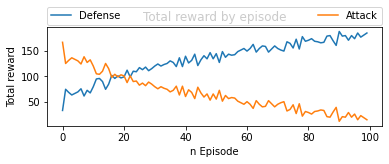

In [26]:
if not os.path.exists('models'):
    os.makedirs('models')
# Save trained model weights and architecture, used in test
defender_agent.model_network.actor_model.save_weights("models/RRIoT_model.h5", overwrite=True)
with open("models/RRIoT_model.json", "w") as outfile:
    json.dump(defender_agent.model_network.actor_model.to_json(), outfile)

    
if not os.path.exists('results'):
    os.makedirs('results')    
# Plot training results
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(len(def_reward_chain)),def_reward_chain,label='Defense')
plt.plot(np.arange(len(att_reward_chain)),att_reward_chain,label='Attack')
plt.title('Total reward by episode')
plt.xlabel('n Episode')
plt.ylabel('Total reward')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

# plt.subplot(212)
# plt.plot(np.arange(len(def_loss_chain)),def_loss_chain,label='Defense')
# plt.plot(np.arange(len(att_loss_chain)),att_loss_chain,label='Attack')
# plt.title('Loss by episode')
# plt.xlabel('n Episode')
# plt.ylabel('loss')
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#        ncol=2, mode="expand", borderaxespad=0.)
# plt.tight_layout()
# #plt.show()
# plt.savefig('results/train_adv.eps', format='eps', dpi=1000)

#### Testing Phase

In [16]:
from keras.models import model_from_json

import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import  confusion_matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
with open("models/RRIoT_model.json", "r") as jfile:
    model = model_from_json(json.load(jfile))
model.load_weights("models/RRIoT_model.h5")

model.compile(loss=huber_loss,optimizer="sgd")


# Define environment, game, make sure the batch_size is the same in train
env_test = RLenv('test')

total_reward = 0    


true_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_correct_labels = np.zeros(len(env_test.attack_types),dtype=int)

states , labels = env_test.get_full()

start_time=time.time()
q = model.predict(states)
actions = np.argmax(q,axis=1)        

320/320 [==============================] - 17s 53ms/step


#### SAGE Analysis

In [19]:
import sage
from sage import PermutationEstimator, MarginalImputer

# Load the model
with open("models/RRIoT_model.json", "r") as jfile:
    model = model_from_json(json.load(jfile))
model.load_weights("models/RRIoT_model.h5")

model.compile(loss=huber_loss,optimizer="sgd")

# Define environment, game
env_test = RLenv('test')

total_reward = 0    

true_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_correct_labels = np.zeros(len(env_test.attack_types),dtype=int)

# Get the states and labels
states , labels = env_test.get_full()

# Setup the SAGE imputer
imputer = sage.MarginalImputer(model, states[:128])

# Now we can use SAGE to interpret the policy
estimator = sage.PermutationEstimator(imputer, 'mse')

start_time = time.time()
q = model.predict(states)
actions = np.argmax(q,axis=1) 

end_time = time.time()
print("Total Test Time: ", end_time-start_time)

Setting up imputer for keras model, assuming that any necessary output activations are applied properly. If not, please set up keras.Sequential with keras.layers.Softmax()
320/320 [==============================] - 17s 52ms/step
Total Test Time:  17.04361367225647


In [20]:
sage_values = estimator(np.array(states), np.array(labels))

  0%|          | 0/1 [00:00<?, ?it/s]

SAGE Explanation(
  (Mean): [ 0.11 -0.09 -0.07 -0.11 -0.11]
  (Std):  [0.01 0.00 0.00 0.00 0.00]
)


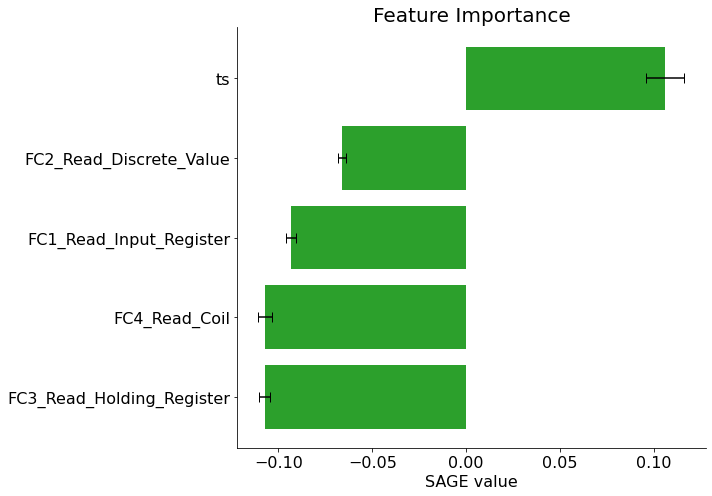

In [21]:
# Plot results
print(sage_values)

feature_names = ['ts', 'FC1_Read_Input_Register','FC2_Read_Discrete_Value',
                 'FC3_Read_Holding_Register','FC4_Read_Coil']

# In this plot, the feature names will include the time stamp feature
sage_values.plot(feature_names)

In [22]:
maped=[]
for indx,label in labels.iterrows():
    maped.append(env_test.attack_types.index(env_test.attack_map[label.idxmax()]))

labels,counts = np.unique(maped,return_counts=True)
true_labels[labels] += counts

for indx,a in enumerate(actions):
    estimated_labels[a] +=1              
    if a == maped[indx]:
        total_reward += 1
        estimated_correct_labels[a] += 1

action_dummies = pd.get_dummies(actions)
posible_actions = np.arange(len(env_test.attack_types))
for non_existing_action in posible_actions:
    if non_existing_action not in action_dummies.columns:
        action_dummies[non_existing_action] = np.uint8(0)
labels_dummies = pd.get_dummies(maped)

normal_f1_score = f1_score(labels_dummies[0].values,action_dummies[0].values)
dos_f1_score = f1_score(labels_dummies[1].values,action_dummies[1].values)
probe_f1_score = f1_score(labels_dummies[2].values,action_dummies[2].values)
r2l_f1_score = f1_score(labels_dummies[3].values,action_dummies[3].values)
u2r_f1_score = f1_score(labels_dummies[4].values,action_dummies[4].values)
    

Accuracy = [normal_f1_score,dos_f1_score,probe_f1_score,r2l_f1_score,u2r_f1_score]
Mismatch = estimated_labels - true_labels

acc = float(100*total_reward/len(states))
print('\r\nTotal reward: {} | Number of samples: {} | Accuracy = {:.2f}%'.format(total_reward,
      len(states),acc))
outputs_df = pd.DataFrame(index = env_test.attack_types,columns = ["Estimated","Correct","Total"])#,"F1_score"])
for indx,att in enumerate(env_test.attack_types):
   outputs_df.iloc[indx].Estimated = estimated_labels[indx]
   outputs_df.iloc[indx].Correct = estimated_correct_labels[indx]
   outputs_df.iloc[indx].Total = true_labels[indx]
   #outputs_df.iloc[indx].F1_score = Accuracy[indx]*100
   outputs_df.iloc[indx].Mismatch = abs(Mismatch[indx])
    
    
print(outputs_df)


Total reward: 9974 | Number of samples: 10222 | Accuracy = 97.57%
          Estimated Correct Total
normal         6933    6932  6932
backdoor        990     986  1009
injection       983     976  1034
password        930     881  1037
xss             264     100   111
scanning        122      99    99


Testing Visualization

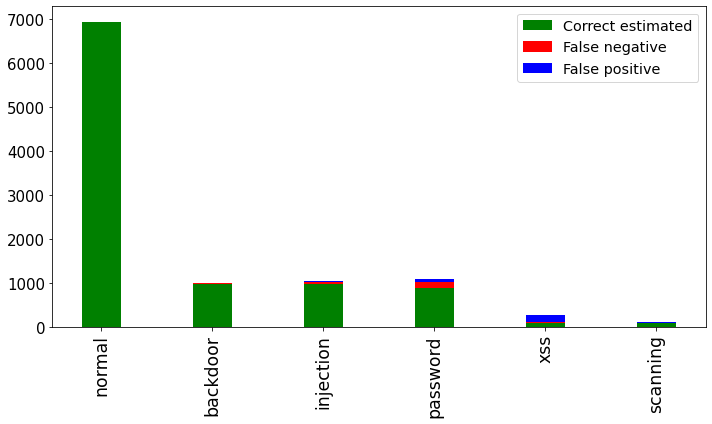

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
width = 0.35
pos = np.arange(len(true_labels))
p1 = plt.bar(pos, estimated_correct_labels, width, color='g') #pos+width

p2 = plt.bar(pos, (np.abs(estimated_correct_labels-true_labels)),width, 
             bottom=estimated_correct_labels, 
             color='r') 

p3 = plt.bar(pos, np.abs(estimated_labels-estimated_correct_labels),width, 
             bottom=estimated_correct_labels+(np.abs(estimated_correct_labels-true_labels)),
             color='b') 

#p2 = plt.bar(pos+width, (np.abs(estimated_correct_labels-true_labels)),width,color='r') #p1
#p3 = plt.bar(pos+width, np.abs(estimated_labels-estimated_correct_labels),width, 
#             bottom=(np.abs(estimated_correct_labels-true_labels)),color='b') #p2

ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticks(pos) #pos+width/2
ax.set_xticklabels(env.attack_types,rotation='vertical',fontsize = 'xx-large')

#ax.set_yscale('log')

#ax.set_ylim([0, 100])
#ax.set_title('Test set scores',fontsize = 'xx-large')
#ax.set_title('Test set scores, Acc = {:.2f}'.format(acc))
plt.legend(('Correct estimated','False negative','False positive'),fontsize = 'x-large')
plt.tight_layout()
#plt.show()
plt.savefig('results/test_adv_imp.svg', format='svg', dpi=1000)


Performance measures on Test data
Accuracy =  0.9757
F1 =  0.9787
Precision_score =  0.9849
Recall_score =  0.9757
G_Mean_Score = 0.9873
Normalized confusion matrix
[[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 9.77e-01 0.00e+00 3.96e-03 1.88e-02 0.00e+00]
 [0.00e+00 0.00e+00 9.44e-01 3.38e-02 0.00e+00 2.22e-02]
 [9.64e-04 2.89e-03 6.75e-03 8.50e-01 1.40e-01 0.00e+00]
 [0.00e+00 9.01e-03 0.00e+00 9.01e-02 9.01e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]]


<Figure size 432x288 with 0 Axes>

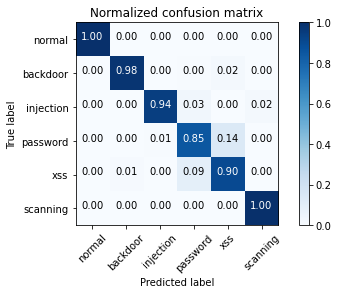

In [24]:
aggregated_data_test = np.array(maped)

print('Performance measures on Test data')
print('Accuracy =  {:.4f}'.format(accuracy_score(aggregated_data_test,actions)))
print('F1 =  {:.4f}'.format(f1_score(aggregated_data_test,actions, average='weighted')))
print('Precision_score =  {:.4f}'.format(precision_score(aggregated_data_test,actions, average='weighted')))
print('Recall_score =  {:.4f}'.format(recall_score(aggregated_data_test,actions, average='weighted')))
print('G_Mean_Score = {:.4f}'.format(geometric_mean_score(aggregated_data_test,actions, average='weighted')))

cnf_matrix = confusion_matrix(aggregated_data_test,actions)
np.set_printoptions(precision=2)
plt.figure()
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=env.attack_types, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('results/confusion_matrix_adversarial.svg', format='svg', dpi=1000)


In [25]:
mapa = {0:'normal', 1:'backdoor', 2:'injection', 3:'password', 4:'xss', 5:'scanning'}
yt_app = pd.Series(maped).map(mapa)

perf_per_class = pd.DataFrame(index=range(len(yt_app.unique())),columns=['name', 'acc', 'f1', 'pre', 'rec', 'gmean'])
for i,x in enumerate(pd.Series(yt_app).value_counts().index):
    y_test_hat_check = pd.Series(actions).map(mapa).copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = pd.Series(maped).map(mapa).copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    gm=geometric_mean_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.iloc[i]=[x,ac,f1,pr,re,gm]
    
print("\r\nOne vs All metrics: \r\n{}".format(perf_per_class))



One vs All metrics: 
        name       acc        f1       pre       rec     gmean
0     normal  0.999902  0.999928  0.999856       1.0  0.999848
1   password  0.979945   0.89578  0.947312  0.849566  0.919257
2  injection  0.993641  0.967774  0.992879  0.943907  0.971179
3   backdoor  0.997359  0.986493   0.99596  0.977205  0.988322
4        xss   0.98288  0.533333  0.378788  0.900901  0.941429
5   scanning   0.99775  0.895928  0.811475       1.0  0.998863
